In [1]:
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt
import nltk
import requests
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
from io import StringIO
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
df = pd.read_csv('ulasan_aplikasi.csv')

In [4]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,e368ea8c-bf99-4c1f-939e-558de91c020d,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Apa si?, mau tf ke bank aja gk bisa, slalu ter...",1,4,3.126.0,2025-02-04 08:40:42,NaN,NaN,3.126.0
1,21b6b6a3-46c2-4d05-92c0-26e416bf3698,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi nggak jelas, udah transfer bukti tran...",1,1,3.126.0,2025-02-04 19:44:49,NaN,NaN,3.126.0
2,f74aaa25-a19b-46af-b72e-d76396ddbd70,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Top up E-money 50ribu dengan nomer kartu gilir...,1,54,3.126.0,2025-02-01 15:38:40,NaN,NaN,3.126.0
3,6304b5bb-bc8b-41ee-b47a-5a2d63cf8292,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Sangat mengecewakan, pengiriman lambat, potong...",1,459,3.123.0,2024-12-16 00:20:17,NaN,NaN,3.123.0
4,ff5e412d-53e8-465c-b607-d92c20250c8b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi paling gak jelas, biaya segala macemn...",1,92,3.124.0,2025-01-15 09:10:09,NaN,NaN,3.124.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202500 entries, 0 to 202499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              202500 non-null  object
 1   userName              202500 non-null  object
 2   userImage             202500 non-null  object
 3   content               202499 non-null  object
 4   score                 202500 non-null  int64 
 5   thumbsUpCount         202500 non-null  int64 
 6   reviewCreatedVersion  157325 non-null  object
 7   at                    202500 non-null  object
 8   replyContent          120740 non-null  object
 9   repliedAt             120740 non-null  object
 10  appVersion            157325 non-null  object
dtypes: int64(2), object(9)
memory usage: 17.0+ MB


In [6]:
df.shape

(202500, 11)

In [7]:
data = df.dropna()

In [8]:
data = data.drop_duplicates()

In [9]:
data.shape

(92601, 11)

In [10]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

In [11]:
def casefoldingText(text):
    text = text.lower()
    return text

In [12]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

In [13]:
def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy","lha","yoi"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

In [14]:
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    words = text.split()

    stemmed_words = [stemmer.stem(word) for word in words]

    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

In [15]:
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [16]:
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "jlk": "jelek"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [17]:
data['text_clean'] = data['content'].apply(cleaningText)

In [18]:
data['text_casefoldingText'] = data['text_clean'].apply(casefoldingText)

In [19]:
data['text_slangwords'] = data['text_casefoldingText'].apply(fix_slangwords)

In [20]:
data['text_tokenizingText'] = data['text_slangwords'].apply(tokenizingText)

In [21]:
data['text_stopword'] = data['text_tokenizingText'].apply(filteringText)

In [22]:
data['text_akhir'] = data['text_stopword'].apply(toSentence)

In [23]:
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])

else:
    print("Failed to fetch positive lexicon data")

In [24]:
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

else:
    print("Failed to fetch negative lexicon data")

In [25]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity=''

    if (score >= 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'

    return score, polarity

In [26]:
results = data['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
data['polarity_score'] = results[0]
data['polarity'] = results[1]
print(data['polarity'].value_counts())

polarity
negative    50394
positive    42207
Name: count, dtype: int64


In [27]:
X = data['text_akhir']
y = data['polarity']

In [28]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8 )
X_tfidf = tfidf.fit_transform(X)

In [29]:
ekstraksi_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [30]:
ekstraksi_df

,admin,aja,akun,alfamart,aneh,apk,aplikasi,aplikasinya,app,bagus,...,udah,udh,ulang,uninstall,update,upgrade,utk,verifikasi,via,yg
0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.408869,0.0,0.0,0.0,0.0,0.000000
1,0.139477,0.188586,0.0,0.0,0.0,0.708790,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.198053
2,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.530947,0.0,0.000000,0.272698,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.000000,0.0,0.0,0.0,0.463699,0.161038,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.194353
4,0.000000,0.241181,0.0,0.0,0.0,0.000000,0.000000,0.0,0.412122,0.000000,...,0.493433,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92596,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
92597,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
92598,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
92599,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [32]:
logistic_regression = LogisticRegression()

logistic_regression.fit(X_train.toarray(), y_train)

y_pred_train = logistic_regression.predict(X_train.toarray())
y_pred_test = logistic_regression.predict(X_test.toarray())

accuracy_train = accuracy_score(y_pred_train, y_train)
accuracy_test = accuracy_score(y_pred_test, y_test)

print('Logistic Regression - accuracy_train:', accuracy_train)
print('Logistic Regression - accuracy_test:', accuracy_test)

Logistic Regression - accuracy_train: 0.8627969762419007
Logistic Regression - accuracy_test: 0.8633443118622105


In [33]:
model = logistic_regression

scores = cross_val_score(model, X_train, y_train, cv=5)
print(f'Skor Cross-Validation: {scores}')
print(f'Rata-rata Akurasi Cross-Validation: {scores.mean()}')

Skor Cross-Validation: [0.86156857 0.86561825 0.86339093 0.86339093 0.8549541 ]
Rata-rata Akurasi Cross-Validation: 0.8617845572354211


In [34]:
cm = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[8671 1486]
 [1045 7319]]


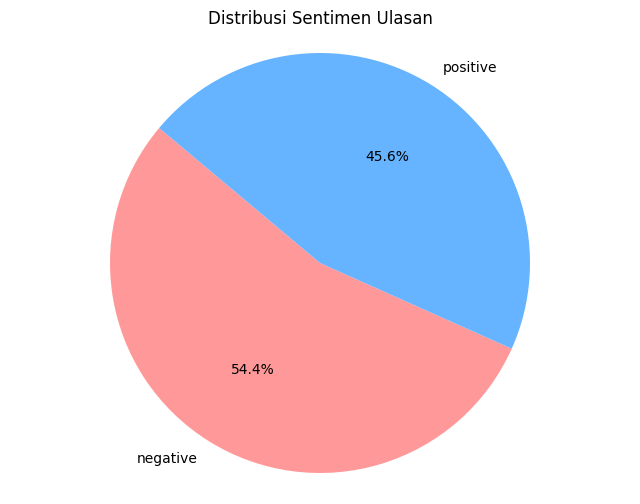

In [35]:
sentiment_counts = data['polarity'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999', '#66b3ff', '#99ff99'])
plt.title('Distribusi Sentimen Ulasan')
plt.axis('equal')
plt.show()

In [36]:
# classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

    negative       0.89      0.85      0.87     10157
    positive       0.83      0.88      0.85      8364

    accuracy                           0.86     18521
   macro avg       0.86      0.86      0.86     18521
weighted avg       0.86      0.86      0.86     18521

